In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import pandas as pd 

import seaborn as sns

import psycopg2

In [2]:
with psycopg2.connect(host='172.18.168.11', dbname='Micaps', user='postgres', password='postgres') as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT station_name, forecast_period, value
            FROM extractions, micaps_files, stations, methods
            WHERE init_time = '2019-08-23 20:00+08' AND model_name='ECMWF_HR' AND element_type='TMP' AND level_type='2M_ABOVE_GROUND' AND city='新乡市' AND method_name='IDW'
            AND micaps_files.id = extractions.micaps_file AND stations.id=extractions.station AND methods.id=extractions.method 
            ORDER BY station_name, forecast_period;
        """)
        model = pd.DataFrame.from_records(cur,columns=['station', 'period', 'tmp'])

In [3]:
df = model.set_index(['station','period'])

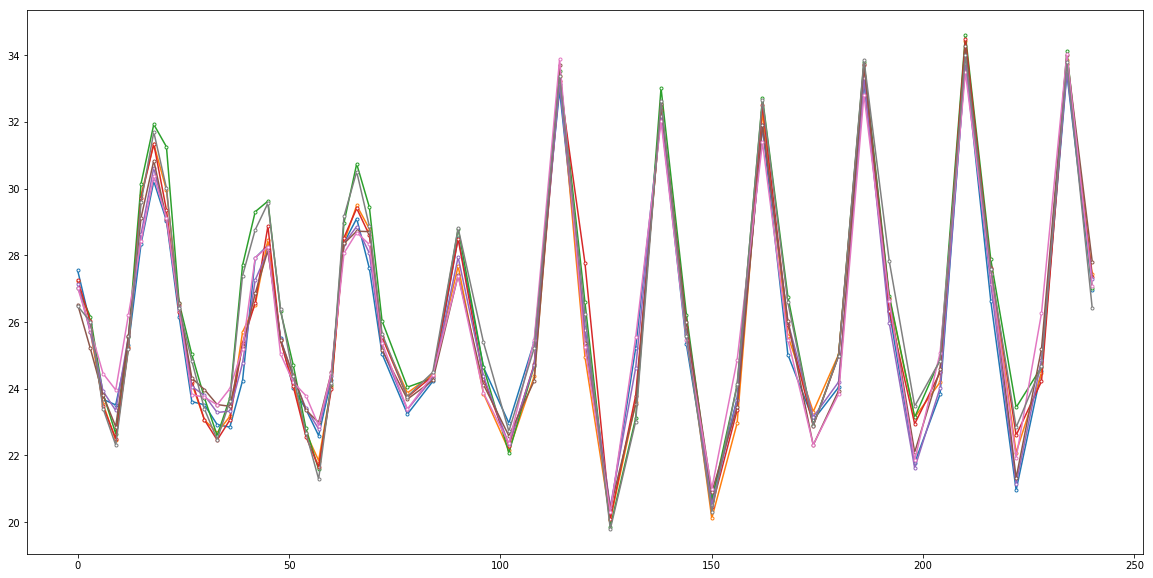

In [4]:
plt.figure(figsize=(20,10))
for station in df.index.levels[0]:
    plt.plot(df.loc[station],marker='o',markersize=3, markerfacecolor='w')
plt.show()

In [5]:
init_time = pd.datetime(2019,8,23,20)

In [6]:
x = pd.to_timedelta(df.loc['新乡'].index, unit='h') + init_time
y = df.loc['新乡']['tmp']

In [7]:
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models.tools import HoverTool
from bokeh.models import DatetimeTicker, DatetimeTickFormatter

In [8]:
output_notebook()
p = figure(x_axis_type="datetime", title="19082320 2m温度预报", plot_width=1000, plot_height=400)
p.line(x, y, line_width=2)
cr = p.circle(x, y, fill_color="white", size=6,
              hover_fill_color="yellow")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='vline'))

#p.xaxis[0].formatter.hours = '%m/%d %H'
p.xaxis[0].formatter = DatetimeTickFormatter(hours=['%m/%d %Hh', '%m/%d %H:%M'], days=['%m/%d %Hh'])
p.xaxis[0].ticker = DatetimeTicker(desired_num_ticks=22, num_minor_ticks=2)
p.xaxis.major_label_orientation = pi/3
show(p)

Loading BokehJS ...

In [9]:
# -*- coding:utf-8 -*-
# @author: ZHU Feng
# @Xinxiang Meteorological Bureau

from datetime import datetime, timedelta

# import sys
# sys.path.insert(1, '/home/zhuf/CodingSpace/pyMicaps')
from pymicaps.utils import latest_init_time
from pymicaps import CIMISSQuery
import json


def daily_max_min_tmp(target_dates, day_span='20', time_zone=8, admin_code='410700'):
    """
     获取一系列日期内的24小时最高最低气温
    :param target_dates: pd.Timestamp类型的日期构成的列表
    :param day_span:
    :param time_zone:
    :param admin_code:
    :return:
    """

    client = CIMISSQuery()
    interface_id = "getSurfEleInRegionByTime"

    data = {}
    for date in target_dates:
        # target_date = datetime.strptime('%s %s:00' % (target_date, day_span), '%Y-%m-%d %H:00')
        target_date = date + timedelta(hours=int(day_span))
        target_date_index = pd.Timestamp(target_date.strftime('%Y-%m-%d %H:00+08'))

        if target_date > datetime.now():
            data[date] = pd.DataFrame(columns=['station_id', 'max_tmp', 'min_tmp'])
            continue

        times = (target_date - timedelta(hours=int(time_zone))).strftime('%Y%m%d%H0000')
        # 参数列表
        params = {'dataCode': 'SURF_CHN_MUL_HOR_N',  # 资料代码（单个）
                  'times': times,  # 时间
                  'adminCodes': admin_code,  # 国内行政编码
                  'elements': 'Station_Id_C,TEM_Max_24h,TEM_Min_24h',  # 要素字段代码；统计接口分组字段
                  }

        result = client.callAPI_to_serializedStr(interface_id, params, dataFormat='json')
        t = json.loads(result)
        if t.get('returnCode', None) != '0':  # 没有数据或查询失败 返回空的dataframe
            df = pd.DataFrame(columns=['station_id', 'max_tmp', 'min_tmp'])
        else:
            df = pd.DataFrame.from_records(t['DS'])

            df.rename(columns={'Station_Id_C': 'station_id', 'TEM_Max_24h': 'max_tmp', 'TEM_Min_24h': 'min_tmp'},
                      inplace=True)
            df[['max_tmp', 'min_tmp']] = df[['max_tmp', 'min_tmp']].astype(float)

            df.set_index('station_id', inplace=True)

            df.columns = pd.MultiIndex.from_product([[target_date_index], ['max_tmp', 'min_tmp']],
                                                    names=['target_date', 'data'])

        data[date] = df

    client.destroy()
    return data


def tmp_forecast_analysis(model_name, element_type, level_type, day_span='20', infer_date=None, before_days=10, after_days=7,
                          city='新乡市', method_name='IDW'):
    """

    :param model_name:
    :param day_span:
    :param infer_date: 参考日期,默认是今天
    :param before_days:
    :param after_days:
    :param city:
    :param method_name:
    :return:
    """
    if infer_date is None:
        infer_date = pd.Timestamp.today().date()
    else:
        infer_date = pd.Timestamp(infer_date).date()

    dates = pd.date_range(infer_date - pd.Timedelta(days=before_days), periods=before_days + after_days)
    truth_dict = daily_max_min_tmp(dates, day_span)

    df_list = []
    with psycopg2.connect(host='172.18.168.11', dbname='Micaps', user='postgres', password='postgres') as conn:
        with conn.cursor() as cur:
            for date in dates:

                target_date = date.strftime('%Y-%m-%d')
                target_date_end = datetime.strptime('%s %s:00' % (target_date, day_span), '%Y-%m-%d %H:00')
                target_date_beg = target_date_end - timedelta(days=1)

                latest_init = latest_init_time('')        # 当前最临近起报时间
                init_min = target_date_end - timedelta(hours=240)    # 根据目标时间计算最早起报时间
                if init_min > latest_init:                        # 如果最早起报时间比最临近起报时间还晚,则没有数据,报错
                    raise Exception('no predict products yet')

                # 根据目标时间计算最晚起报时间,为了获取完整的24h,需要考虑目标时间的左边界与最临近起报时间的大小
                init_max = target_date_beg if target_date_beg <= latest_init else latest_init

                target_date_beg = target_date_beg.strftime('%Y-%m-%d %H:00+08')
                target_date_end = target_date_end.strftime('%Y-%m-%d %H:00+08')
                init_min = init_min.strftime('%Y-%m-%d %H:00+08')
                init_max = init_max.strftime('%Y-%m-%d %H:00+08')

                cur.execute('''SELECT station, (%s - init_time) AS forecast_period, init_time, max(value), min(value)
                               FROM extractions, stations, methods, micaps_files
                               WHERE station=stations.id and method=methods.id AND micaps_file=micaps_files.id and
                               model_name=%s AND element_type=%s AND level_type=%s AND method_name=%s AND city=%s AND
                               init_time + (forecast_period::text || ' hours')::interval >=%s AND
                               init_time + (forecast_period::text || ' hours')::interval <=%s AND
                               init_time >= %s AND init_time <= %s
                               GROUP BY station, init_time
                               ORDER BY station, init_time
                            ''', (target_date_end, model_name, element_type, level_type, method_name, city,
                                  target_date_beg, target_date_end, init_min, init_max))

                model = pd.DataFrame.from_records(cur, columns=['station_id', 'forecast_period', 'init_time',
                                                                'max_tmp', 'min_tmp'])
                model.set_index(['station_id', 'forecast_period'], inplace=True)
                model.columns = pd.MultiIndex.from_product([[pd.Timestamp(target_date_end)],
                                                            ['init_time', 'max_tmp', 'min_tmp']],
                                                           names=['target_date', 'data'])
                # 计算预报误差
                truth = truth_dict[date]
                if not truth.empty:  # 还没有实况的不计算
                    model.iloc[:, [1, 2]] = model.iloc[:, [1, 2]] - truth
                    model.rename(columns={'max_tmp': 'max_tmp_error', 'min_tmp': 'min_tmp_error'}, inplace=True)
                    # result = pd.concat([model, error], axis=1)

                df_list.append(model)

    merged = pd.concat(df_list, axis=1)
    return merged


def predict_trend(model_name, target_date, day_span='20', method_name='IDW'):
    """
    分组统计查询每个站点上不同起报时次在固定时间段内的最高最低气温
    :param model_name:
    :param target_date:
    :param day_span:
    :param method_name:
    :return:
    """
    target_date_end = datetime.strptime('%s %s:00' % (target_date, day_span), '%Y-%m-%d %H:00')
    target_date_beg = target_date_end - timedelta(days=1)

    latest_init = latest_init_time('')
    init_min = target_date_end - timedelta(hours=240)
    if init_min > latest_init:
        raise Exception('no predict products yet')
    init_max = target_date_beg if target_date_beg <= latest_init else latest_init

    target_date_beg = target_date_beg.strftime('%Y-%m-%d %H:00+08')
    target_date_end = target_date_end.strftime('%Y-%m-%d %H:00+08')
    init_min = init_min.strftime('%Y-%m-%d %H:00+08')
    init_max = init_max.strftime('%Y-%m-%d %H:00+08')

    with psycopg2.connect(host='172.18.168.11', dbname='Micaps', user='postgres', password='postgres') as conn:
        with conn.cursor() as cur:
            cur.execute('''SELECT station, (%s - init_time) as forecast_period, init_time, max(value), min(value)
                           FROM extractions, stations, methods, micaps_files
                           WHERE station=stations.id and method=methods.id and micaps_file=micaps_files.id and
                           model_name=%s and method_name=%s and city='新乡市' and
                           init_time + (forecast_period::text || ' hours')::interval >=%s and
                           init_time + (forecast_period::text || ' hours')::interval <=%s and
                           init_time >= %s and init_time <= %s
                           GROUP BY station, init_time
                           ORDER BY station, init_time
                        ''', (target_date_end, model_name, method_name, target_date_beg, target_date_end,
                              init_min, init_max))

            df = pd.DataFrame.from_records(cur, columns=['station_id', 'forecast_period', 'init_time',
                                                         'max_tmp', 'min_tmp'])
            df.set_index(['station_id', 'forecast_period'], inplace=True)
            df.columns = pd.MultiIndex.from_product([[pd.Timestamp(target_date_end)],
                                                     ['init_time', 'max_tmp', 'min_tmp']],
                                                    names=['target_date', 'data'])
    return df


def get_max_min_tmp(target_date, day_span='20', admin_code='410700', time_zone=8):
    target_date = datetime.strptime('%s %s:00' % (target_date, day_span), '%Y-%m-%d %H:00')
    target_date_index = target_date.strftime('%Y-%m-%d %H:00+08')
    times = (target_date - timedelta(hours=time_zone)).strftime('%Y%m%d%H0000')

    client = CIMISSQuery()

    interface_id = "getSurfEleInRegionByTime"

    # 参数列表
    params = {'dataCode': 'SURF_CHN_MUL_HOR_N',  # 资料代码（单个）
              'times': times,  # 时间
              'adminCodes': admin_code,  # 国内行政编码
              'elements': 'Station_Id_C,TEM_Max_24h,TEM_Min_24h',  # 要素字段代码；统计接口分组字段
              }

    result = client.callAPI_to_serializedStr(interface_id, params, dataFormat='json')

    client.destroy()

    t = json.loads(result)
    if t.get('returnCode', None) != '0':  # 没有数据或查询失败 返回空的dataframe
        df = pd.DataFrame(columns=['station_id', 'max_tmp', 'min_tmp'])
    else:
        df = pd.DataFrame.from_records(t['DS'])

        df.rename(columns={'Station_Id_C': 'station_id', 'TEM_Max_24h': 'max_tmp', 'TEM_Min_24h': 'min_tmp'},
                  inplace=True)
        df[['max_tmp', 'min_tmp']] = df[['max_tmp', 'min_tmp']].astype(float)

        df.set_index('station_id', inplace=True)

        df.columns = pd.MultiIndex.from_product([[pd.Timestamp(target_date_index)],
                                                 ['max_tmp', 'min_tmp']], names=['target_date', 'data'])

    return df


def init_time_span(target_date, day_span='20', format='%Y-%m-%d %H:00'):
    target_date_end = datetime.strptime('%s %s:00' % (target_date, day_span), '%Y-%m-%d %H:00')

    target_date_beg = target_date_end - timedelta(days=1)
    latest_init = latest_init_time('')

    init_min = target_date_end - timedelta(hours=240)
    if init_min > latest_init:
        raise Exception('no predict products')
    init_max = target_date_beg if target_date_beg <= latest_init else latest_init

    init_time = init_min
    while init_time <= init_max:
        yield init_time.strftime(format)
        init_time = init_time + timedelta(hours=12)


def validation_comparision(target_date, day_span='20'):
    model = predict_trend('ECMWF_HR', target_date, day_span)
    truth = get_max_min_tmp(target_date, day_span)

    if not truth.empty:
        model.iloc[:, [1, 2]] = model.iloc[:, [1, 2]] - truth
        model.rename(columns={'max_tmp': 'max_tmp_error', 'min_tmp': 'min_tmp_error'}, inplace=True)
        # result = pd.concat([model, error], axis=1)
    return model


d = tmp_forecast_analysis('ECMWF_HR','TMP','2M_ABOVE_GROUND', '08')
#d.to_csv('2019-08-20 08.csv')


In [57]:
df = d.loc['53983']

In [58]:
#ddf =df.iloc[:, [i for i in range(df.shape[1]) if i%3==2]].iloc[:,:11]

ddf = df.xs('max_tmp_error', level = 'data',axis=1,drop_level=True)
ddf.columns = ddf.columns.strftime('%m%d%H')

mx = ddf.max().max()
mn = ddf.min().min()

In [59]:
colormap =cm.get_cmap("bwr")
color_palette = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]



def background_color(val):
    """
    """
    if val<=0:
        index = int(128-128*val/mn)
    else:
        index = int(128+128*val/mx)
    if index<0:
        index = 0
    elif index>255:
        index = 255
        
    color = color_palette[index]
    return 'background-color: %s' % color

In [60]:
# pd.set_option('display.width', 10)
# cm = sns.light_palette("green", as_cmap=True)
# cm = sns.diverging_palette(240, 10, sep = 20,as_cmap=True)
#  = sns.diverging_palette(260, 0, sep=50, as_cmap=True)
#sns.palplot(cm)

result = (ddf.style
              .applymap(background_color)
             #.background_gradient(cmap=cm)
             .format("{:<+.1f}")
             .set_caption("EC 2T validation"))
result

,081408,081508,081608,081708,081808,081908,082008,082108,082208,082308,082408
forecast_period,,,,,,,,,,,
1 days 00:00:00,-1.9,-1.5,-1.2,-0.8,-0.8,+0.2,+1.4,+1.8,+0.6,-0.9,+0.1
1 days 12:00:00,-1.7,-1.9,-1.0,+0.0,-0.8,+0.2,+1.4,+0.9,-1.7,-0.6,+0.0
2 days 00:00:00,-2.7,-1.9,-1.6,+0.0,-0.8,+0.0,+1.3,+0.2,-1.9,-0.1,-0.4
2 days 12:00:00,-1.4,-1.7,-1.6,+0.2,-0.5,+0.1,+1.0,+1.6,-0.5,-0.7,+0.3
3 days 00:00:00,-1.5,-2.1,-1.8,-0.1,-0.8,+0.1,+0.8,+0.7,+2.3,-2.1,+0.5
3 days 12:00:00,-0.9,-1.7,-1.7,-1.1,-0.4,+0.1,+0.9,+0.6,+1.8,+0.4,+0.2
4 days 00:00:00,+1.5,-5.7,-1.7,-1.2,-0.4,-0.4,+0.9,+0.4,+1.0,+0.3,-1.2
4 days 12:00:00,+0.2,-1.8,-1.6,-0.0,-0.4,+0.0,+0.6,+0.4,+5.5,-0.3,+1.0
5 days 00:00:00,+0.7,-0.1,-1.9,+2.9,-0.9,+0.2,+1.5,+1.6,+4.6,-3.6,+1.2


In [61]:
ddf.describe()

,081408,081508,081608,081708,081808,081908,082008,082108,082208,082308,082408
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,-0.134942,-0.972079,-1.707032,0.891253,0.052347,0.573858,1.459321,1.214100,3.949663,-0.375826,-0.538579
std,2.520141,1.988270,1.007153,2.889182,2.170954,1.596318,1.172624,1.134627,3.438222,1.809934,1.660469
min,-7.371900,-5.700700,-4.585000,-8.525800,-5.388700,-2.135500,-0.802200,-0.433700,-1.858100,-4.145400,-4.014500
25%,-1.528950,-1.811050,-2.118850,-0.079550,-0.847750,0.000400,0.828000,0.516100,1.367150,-1.209650,-0.976600
50%,0.236100,-1.151000,-1.649400,0.923100,-0.521000,0.114700,1.290100,0.918400,3.724000,-0.295800,0.069600
75%,1.494350,0.592850,-1.101700,3.030700,1.206000,1.137400,1.565700,1.695000,7.194350,1.087050,0.396450
max,3.815600,2.042100,-0.355000,4.272600,3.869800,3.705600,4.481100,4.266100,8.477400,2.466700,1.646100
